In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torchvision.transforms.functional as tv
import PIL
import random
from delegation import delegates
from Layers import *
import fastai.vision.all as fv
from autoencoder import create_autoencoder

/home/mraggi/mambaforge/envs/fastai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.transforms.functional import to_tensor, to_pil_image

In [3]:
torch.cuda.set_device(1)

In [4]:
#alumnos = ["Humberto", "Gerardo", "Tania", 
#           "Arnold", 
#           "Leo Grande", "Leo chico", 
#           "Diego", "Dani", "Miguel"]

In [5]:
#random.choice(alumnos)

In [6]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms()
    
    data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.ImageBlock),
                        get_items = fv.get_image_files,
                        get_y     = lambda x: x,
                        splitter  = fv.RandomSplitter(.05,seed = 27),
                        item_tfms = fv.Resize(img_size),
                        batch_tfms= tfms,
                     )
    return data.dataloaders(folder, bs=batch_size)

In [7]:
dls = load_data("facesM", 128, 48)

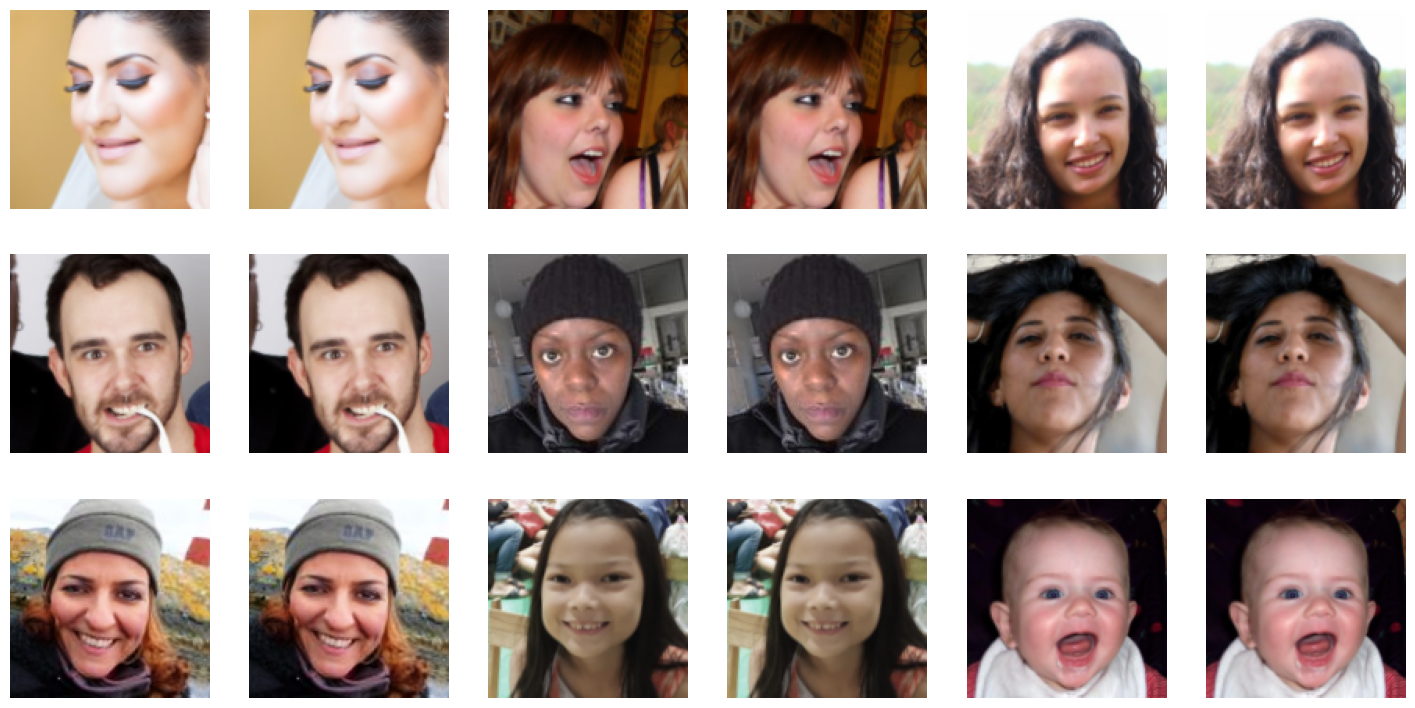

In [8]:
dls.show_batch()

In [9]:
A = create_autoencoder()

/home/mraggi/mambaforge/envs/fastai/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [10]:
def similarity_to_normal(x):
    μ = x.mean()
    σ = x.std()
    z = (x-μ)/σ
    z2 = z*z
    
    # skewness = E[((x - μ) / σ)^3]
    skew = torch.mean(z2*z)

    # kurtosis = E[((x - μ) / σ)^4]
    kurt = torch.mean(z2*z2)

    # La normal tiene media 0, std 1, skew 0 y kurt 3
    expected_values = torch.tensor([0.0, 1.0, 0.0, 3.0], device=x.device)
    actual_values = torch.stack([μ,σ,skew, kurt])

    # kl = 1/2(μ² + var - 1 - ln(var))
    #kl = μ*μ + var - torch.log(var) # me da infs

    return F.smooth_l1_loss(actual_values, expected_values)

In [11]:
def metric_kl_div(yp,y):
    z = A.z
    μ = torch.mean(z)
    var = torch.var(z, unbiased=False)
    
    return (var + μ*μ - torch.log(var)-1)*0.5

def metric_similarity_to_normal(yp, y):
    return similarity_to_normal(A.z)
    
def metric_mean(yp, y):
    return A.z.mean()
    
def metric_std(yp, y):
    return A.z.std()
    
def metric_skew(yp, y):
    z = (A.z - A.z.mean()) / A.z.std()
    return (z**3).mean()
    
def metric_kurt(yp, y):
    z = (A.z - A.z.mean()) / A.z.std()
    return (z**4).mean()

In [12]:
def mse_plus_similarity(yp, y):
    return F.smooth_l1_loss(yp,y)*16 + similarity_to_normal(A.z)*16

In [13]:
learn = fv.Learner(dls,A,
                   loss_func=mse_plus_similarity,
                   wd=0.05,
                   wd_bn_bias=True,
                   opt_func=fv.ranger,
                   metrics=[F.smooth_l1_loss, metric_similarity_to_normal, metric_kl_div, metric_mean, metric_std, metric_skew, metric_kurt],
                   cbs=[fv.GradientClip(0.2)]).to_fp16()

SuggestedLRs(valley=0.0004786300996784121)

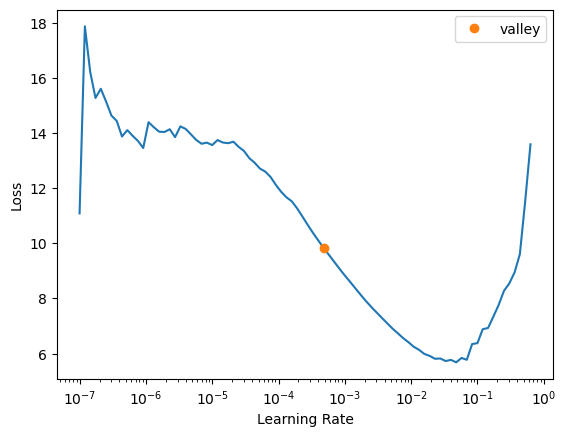

In [14]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(20,1e-3,pct_start=0.7,div=1)

epoch,train_loss,valid_loss,smooth_l1_loss,metric_similarity_to_normal,metric_kl_div,metric_mean,metric_std,metric_skew,metric_kurt,time
0,0.087905,0.141019,0.005290,0.003524,0.001645,-0.005367,1.014648,0.117432,3.042969,01:40
1,0.048772,0.080796,0.003535,0.001515,0.001897,-0.033386,0.990234,-0.046509,2.966797,01:41
2,0.037925,0.041762,0.001679,0.000931,0.001096,-0.003452,0.990234,-0.012367,3.029297,01:41
3,0.034492,0.039623,0.001338,0.001138,0.001021,-0.014717,1.006836,0.055420,2.986328,01:41
4,0.033878,0.120276,0.003447,0.004070,0.001392,0.029160,1.010742,-0.129150,2.900391,01:41
5,0.033876,0.044234,0.001432,0.001332,0.000792,-0.003431,0.995605,-0.055878,3.044922,01:42
6,0.033866,0.034666,0.001426,0.000741,0.000820,-0.000883,0.992188,-0.022598,2.968750,01:42
7,0.032622,0.060567,0.001947,0.001839,0.001778,0.009781,1.034180,0.059570,2.923828,01:42
8,0.030092,0.023413,0.000943,0.000520,0.000948,-0.002836,1.007812,0.015572,2.996094,01:42
9,0.025901,0.029297,0.001361,0.000470,0.000769,-0.008965,1.004883,0.020294,2.996094,01:42


In [16]:
x,y = dls.one_batch()

In [17]:
z = A.encode(x)

In [18]:
z = z.detach().cpu().numpy()

In [19]:
import matplotlib.pyplot as plt

(array([6.5300e+02, 1.3830e+03, 2.1930e+03, 2.6630e+03, 2.9700e+03,
        3.1260e+03, 3.4780e+03, 3.7610e+03, 4.7600e+03, 7.3190e+03,
        1.1203e+04, 1.4066e+04, 1.4913e+04, 1.4149e+04, 1.2332e+04,
        9.3730e+03, 7.5470e+03, 6.1170e+03, 5.1170e+03, 4.5460e+03,
        4.2360e+03, 3.5780e+03, 3.2040e+03, 2.2420e+03, 1.3150e+03,
        7.3000e+02, 3.1700e+02, 1.1400e+02, 4.2000e+01, 9.0000e+00]),
 array([-2.67493248, -2.47690725, -2.27888179, -2.08085656, -1.88283122,
        -1.68480587, -1.48678052, -1.28875518, -1.09072995, -0.89270461,
        -0.69467926, -0.49665394, -0.29862863, -0.1006033 ,  0.09742203,
         0.29544735,  0.49347267,  0.69149798,  0.88952333,  1.08754861,
         1.28557396,  1.48359931,  1.68162465,  1.87964988,  2.07767534,
         2.27570057,  2.4737258 ,  2.67175126,  2.86977649,  3.06780195,
         3.26582718]),
 <BarContainer object of 30 artists>)

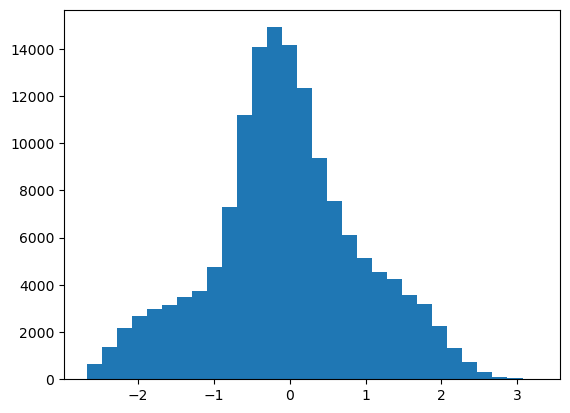

In [20]:
plt.hist(z.flatten(),bins=30)

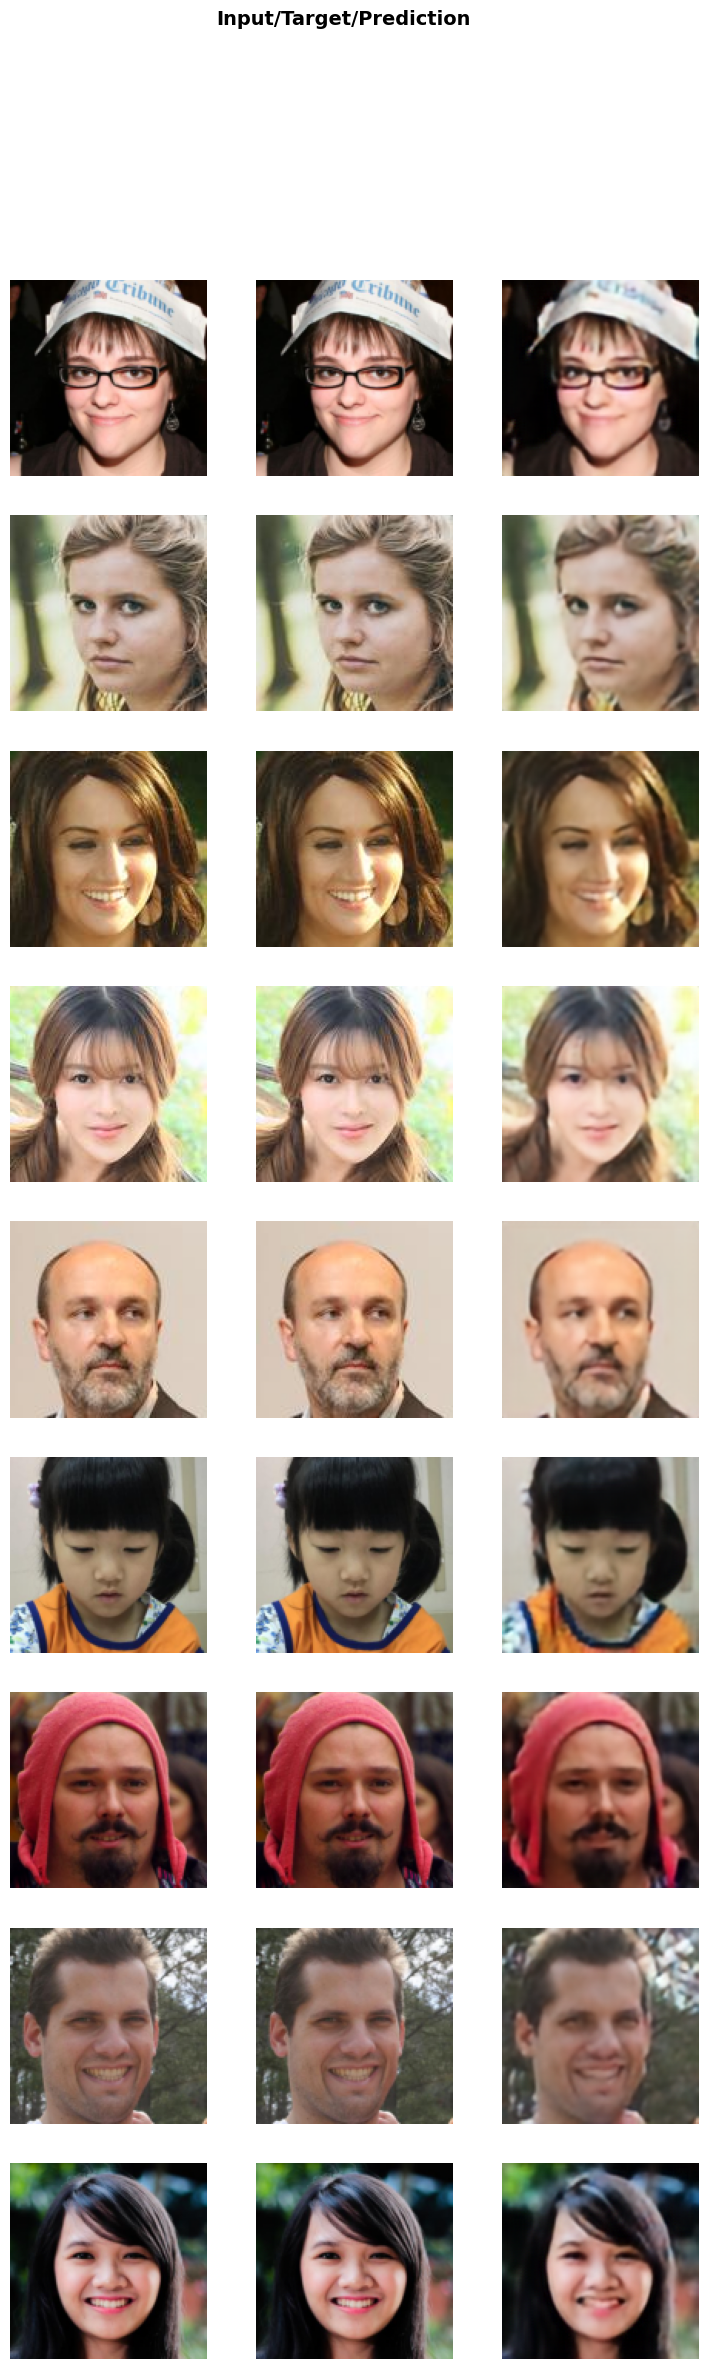

In [21]:
learn.show_results()

In [22]:
learn.save("MSE")

Path('models/MSE.pth')

In [23]:
#learn.load("MSE")

In [24]:
#learn.model.cpu()

In [25]:
#learn.model

In [26]:
from PerceptualLoss import perceptual_loss

In [27]:
ploss = perceptual_loss().cuda()

/home/mraggi/mambaforge/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mraggi/mambaforge/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
def perceptual_w_sim(yp, y):
    return ploss(yp,y) + similarity_to_normal(A.z)*32

In [29]:
learn.loss_func = perceptual_w_sim
learn.dls.train.bs = 24
learn.dls.valid.bs = 24

In [30]:
learn.fit_one_cycle(25, 1e-3, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,smooth_l1_loss,metric_similarity_to_normal,metric_kl_div,metric_mean,metric_std,metric_skew,metric_kurt,time
0,1.358650,1.566555,0.001601,0.000955,0.001568,0.002581,1.023438,0.006237,3.029297,02:16
1,1.263180,1.486590,0.002129,0.001539,0.003197,0.007103,1.046875,0.028763,2.943359,02:17
2,1.200723,1.402472,0.001013,0.001041,0.002102,0.004723,1.036133,0.010124,3.021484,02:15
3,1.178545,1.383372,0.001120,0.001207,0.001654,-0.002537,1.031250,-0.015900,3.044922,02:16
4,1.132309,1.313908,0.001104,0.001229,0.002352,0.020584,1.040039,-0.039459,3.017578,02:16
5,1.108919,1.352908,0.001804,0.001267,0.002382,0.006973,1.041016,-0.001708,3.041016,02:16
6,1.136350,1.402347,0.000998,0.003628,0.004353,-0.022507,1.059570,0.042847,2.869141,02:16
7,1.069474,1.224755,0.001020,0.001077,0.001442,0.015915,1.028320,-0.047913,3.000000,02:17
8,1.043357,1.193613,0.000933,0.000809,0.002100,0.001604,1.039062,-0.001615,2.992188,02:16
9,1.037807,1.217062,0.000798,0.000849,0.001472,0.010811,1.028320,0.005550,2.976562,02:16


In [31]:
learn.save("Perceptual")

Path('models/Perceptual.pth')

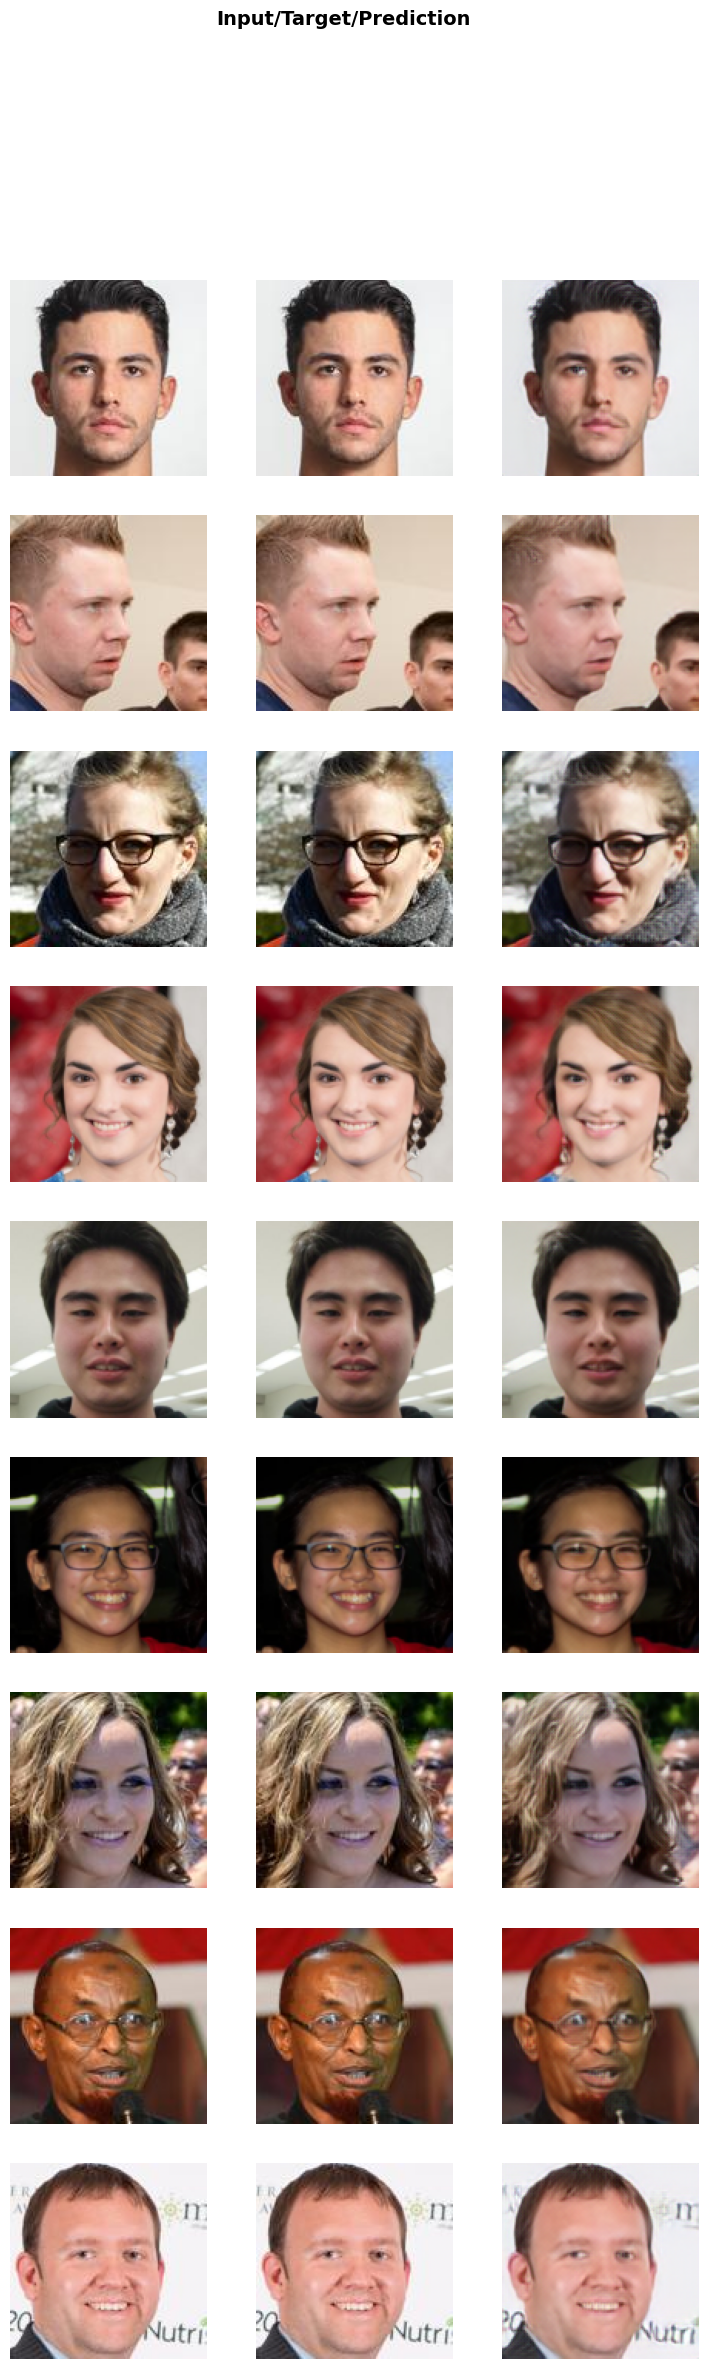

In [33]:
learn.show_results()

In [ ]:
x,y = dls.one_batch()

In [ ]:
z = A.encode(x)

In [ ]:
z = z.detach().cpu().numpy()

In [ ]:
plt.hist(z.flatten(),bins=30)

In [ ]:
#f = fv.PILImage.create("facesM/30_1_28985.jpg")

In [ ]:
#learn.model.encoder(to_tensor(f)[None])

In [ ]:
#x = torch.randn(1,3,32,32)
#learn.model.eval().cpu()
#img_de_latente_aleatorio = learn.model.decoder(x)

#to_pil_image(img_de_latente_aleatorio[0].clamp(0,1))

In [ ]:
normal_kl_divergence(torch.randn(32,3,18,18))

## Arreglos que hice:
- Había un bug en ResBlock: poníamos
```python
if faltan>0:
    x = torch.cat bla bla bla
...
return self.act(x+self.m(x))
```
pero ese `self.m(x)` sí debía usar al original, no al concatenado

- Quité algunos self attentions, porque como es cuadrático se acaba la memoria bien fácil, sólo dejé los self attentions
- Bajé la resolución y el batch size, agregué to_fp16, igual para bajar la memoria
- Al mero final quité el batch norm del decoder. Las imágenes producidas no tienen por qué tener media 0 y desviación 1 ni nada así.

## Arreglos que faltan:
- Perceptual loss
- Muchos más canales (yo creo)
- En Resblock, cuando el # de canales de x es > número de canales de salida, simplemente cortamos, y entonces perdemos toda la información! No queremos eso, yo creo que deberíamos hacer una convolución con kernel_size = 1 para reducir el número de canales.
- Cómo se entrena con 2 GPU's?
- Saqué ese self attention de deepseek. Yo siento que gamma debería tener un parámetro por canal, no solo 1 parámetro. Quizás haya canales más importantes que otros.